In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, concatenate, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import json
import time

In [2]:
# Load data
data = pd.read_csv('train.csv')
claims = data['Claim'].tolist()
evidence = data['Evidence'].tolist()
labels = data['label'].values

In [3]:
data.head()

,Claim,Evidence,label
0,We should legalize the growing of coca leaf,"Robert W. Sweet, a federal judge, strongly agr...",1
1,We should ban trans fats usage in food,The net increase in LDL/HDL ratio with trans f...,1
2,We should legalize prostitution,"Pertaining to health, safety and services, the...",0
3,We should subsidize investigative journalism,"Date granted: 10 June 2002 Citation: ""For serv...",0
4,We should abolish homework,The Yarrabah community has a public library wh...,0


In [4]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(claims + evidence)  # Fit tokenizer on both claims and evidence

# Convert texts to sequences
claims_seq = tokenizer.texts_to_sequences(claims)
evidence_seq = tokenizer.texts_to_sequences(evidence)

# Padding
# Determine max lengths separately 
max_length_claims = max(len(x) for x in claims_seq)
max_length_evidence = max(len(x) for x in evidence_seq)

# Apply padding
claims_pad = pad_sequences(claims_seq, maxlen=max_length_claims)
evidence_pad = pad_sequences(evidence_seq, maxlen=max_length_evidence)

# Model architecture with dual input
input_claims = Input(shape=(max_length_claims,), dtype='int32')
input_evidence = Input(shape=(max_length_evidence,), dtype='int32')

# Embedding layers
embedding_layer_claims = Embedding(input_dim=5000, output_dim=64, input_length=max_length_claims)
embedding_layer_evidence = Embedding(input_dim=5000, output_dim=64, input_length=max_length_evidence)

claims_embeddings = embedding_layer_claims(input_claims)
evidence_embeddings = embedding_layer_evidence(input_evidence)

# LSTM layers
claims_lstm = Bidirectional(LSTM(64, return_sequences=True))(claims_embeddings)
claims_lstm = Bidirectional(LSTM(32))(claims_lstm)

evidence_lstm = Bidirectional(LSTM(64, return_sequences=True))(evidence_embeddings)
evidence_lstm = Bidirectional(LSTM(32))(evidence_lstm)

# Concatenate the outputs of the two branches
combined = concatenate([claims_lstm, evidence_lstm])

# Possibly add dropout here
dropout_layer = Dropout(0.1)(combined)

# Output layer
output = Dense(1, activation='sigmoid')(dropout_layer)

model = Model(inputs=[input_claims, input_evidence], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 273)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 28, 64)       320000      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 273, 64)      320000      ['input_2[0][0]']                
                                                                                              

# Train the model

In [5]:
start_time = time.time()

# Train the model using validation_split
history = model.fit([claims_pad, evidence_pad], labels, batch_size=256, epochs=3, validation_split=0.2)

end_time = time.time()

Epoch 1/3
75/75 [==============================] - 15s 70ms/step - loss: 0.5305 - accuracy: 0.7432 - val_loss: 0.4149 - val_accuracy: 0.8049
Epoch 2/3
75/75 [==============================] - 3s 45ms/step - loss: 0.3600 - accuracy: 0.8353 - val_loss: 0.4094 - val_accuracy: 0.7984
Epoch 3/3
75/75 [==============================] - 3s 46ms/step - loss: 0.2934 - accuracy: 0.8718 - val_loss: 0.4175 - val_accuracy: 0.8163


In [6]:
training_time = end_time - start_time
print("Overall Training Time:", training_time, "seconds")

# Calculate duration per training epoch
epoch_duration = training_time / 3  # Assuming 3 epochs
print("Duration per Training Epoch:", epoch_duration, "seconds")

Overall Training Time: 22.331351041793823 seconds
Duration per Training Epoch: 7.443783680597941 seconds


In [7]:
import os
# Saving the model
model_name = 'Bi_LSTM_ED.h5'
model.save(model_name)

# Get the size of the saved model file
model_size_bytes = os.path.getsize(model_name)
model_size_MB = model_size_bytes / (1024 * 1024)  # Convert bytes to MB
print("Model Size:", model_size_MB, "MB")

# Save the tokenizer using pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the max lengths using JSON
lengths = {
    'max_length_claims': max_length_claims,
    'max_length_evidence': max_length_evidence
}
with open('lengths.json', 'w') as f:
    json.dump(lengths, f)

Model Size: 9.910888671875 MB


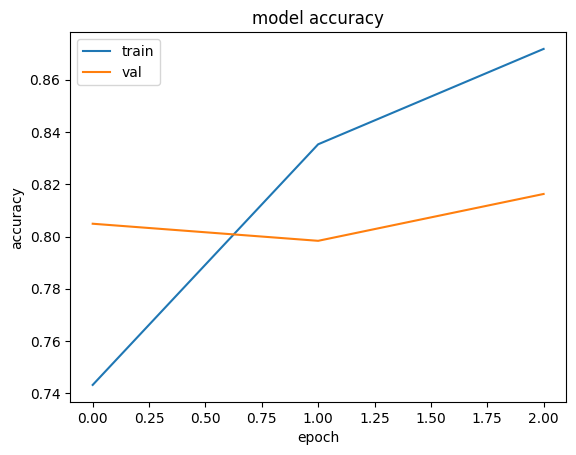

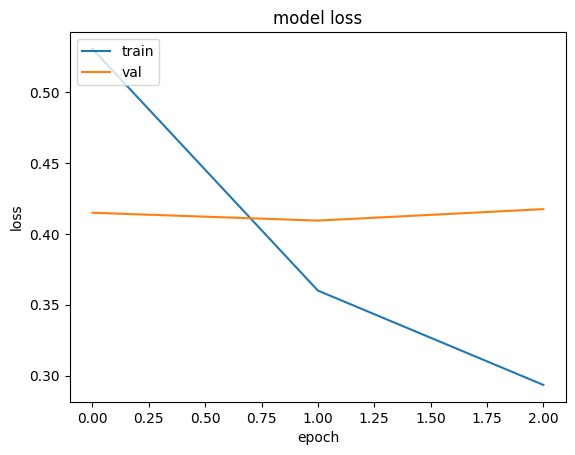

In [8]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the test data
test_data = pd.read_csv('dev.csv')
test_claims = test_data['Claim'].tolist()
test_evidence = test_data['Evidence'].tolist()
test_labels = test_data['label'].values

# Tokenize and pad the test data for claims
test_claims_seq = tokenizer.texts_to_sequences(test_claims)
test_claims_pad = pad_sequences(test_claims_seq, maxlen=max_length_claims)

# Tokenize and pad the test data for evidence - correct this line
test_evidence_seq = tokenizer.texts_to_sequences(test_evidence)
test_evidence_pad = pad_sequences(test_evidence_seq, maxlen=max_length_evidence)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([test_claims_pad, test_evidence_pad], test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict classes or probabilities
predictions = model.predict([test_claims_pad, test_evidence_pad])
predictions = (predictions > 0.5).astype('int32')  # Converting probabilities to binary output

# Print classification report
print(classification_report(test_labels, predictions))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(test_labels, predictions))

# Calculate ROC AUC Score
roc_auc = roc_auc_score(test_labels, predictions)
print("ROC AUC Score:", roc_auc)

186/186 [==============================] - 2s 13ms/step - loss: 0.4210 - accuracy: 0.8132
Test Loss: 0.421029657125473
Test Accuracy: 0.813196063041687
186/186 [==============================] - 4s 13ms/step
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4327
           1       0.69      0.55      0.61      1599

    accuracy                           0.81      5926
   macro avg       0.77      0.73      0.75      5926
weighted avg       0.80      0.81      0.81      5926

Confusion Matrix:
[[3937  390]
 [ 717  882]]
ROC AUC Score: 0.7307315078626245
